### Mike Ogrysko
### CS 766 Information Retrieval and Natural Language Processing

Processing the IMDB movie reviews for sentiment analysis with PyTorch Feedforward Neural Network
- TFIDF matrix with 1000 top features
- 10-fold classification evaluation function
- PyTorch feed forward neural network with 1 hidden layer - input and hidden layers with ReLU activation and output with Softmax activation
- Tune the hyper-parameter eta and plot the performance on various eta values

In [1]:
import csv
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, adjusted_rand_score
from sklearn.svm import LinearSVC
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import word_tokenize
from nltk.tokenize import wordpunct_tokenize
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

**TFIDF matrix with 1000 top features**

In [2]:
#combination of stop words and punctuations, also get rid of br
stop_words = stopwords.words('english') + list(punctuation)
stop_words_set = set(stop_words) | set(['br']) | set(['p']) | set(['the']) | set(['this']) | set(['etc'])

#develop tokenizer
def tokenize(text):
    terms = word_tokenize(text)
    #all lower case
    terms = [w.lower() for w in terms]
    #filter stop words
    terms = [w for w in terms if w not in stop_words_set and not w.isdigit()]
    #regex for contractions and other special character strings
    terms = [w for w in terms if not re.search(r'^\W+|\w\'\w+|\'\w+$', w)]
    terms = [w for w in terms if not re.search(r'^[^a-z]+$', w)]
    #regex for words two letters or less and numbers
    terms = [w for w in terms if not re.search(r'^\b\w{1,2}\b|(?<!\S)\d+(?!\S)$', w)]
    #lemmatize
    lemmatizer = WordNetLemmatizer()
    terms = [lemmatizer.lemmatize(w, 'n') for w in terms]
    return terms


In [5]:
Reviews, Sentiments = [], []

with open('movie_data.csv','r', encoding='utf8') as fin:
    reader = csv.reader(fin, delimiter=',', quotechar='"')
    header = next(reader)
    for i, line in enumerate(reader):
        Reviews += [line[0]]
        Sentiments +=[int(line[1])]

N=len(Reviews)
M=len(Sentiments)
print('Total reviews loaded', N)
print('Total sentiments loaded', M)


Total reviews loaded 50000
Total sentiments loaded 50000


In [6]:
#tokenize reviews
Reviews_Tok=[tokenize(review) for review in Reviews]


In [7]:
#tokenize reviews and put them back together as strings
Review_tok_2 = []
for review in Reviews:
    rev = ""
    terms = tokenize(review)
    for term in terms:
        rev += term + ' '
    Review_tok_2.append(rev)

In [8]:
#set tfidf with 1000 max features
tfidf = TfidfVectorizer(dtype=np.float32, max_features=1000)

In [9]:
#fit reviews to tfidf
X_tfidf = tfidf.fit_transform(Review_tok_2)


In [10]:
#check counts, size of the X dataset - raw features
print(f'N data points= {X_tfidf.shape[0]}, M features= {X_tfidf.shape[1]}')

N data points= 50000, M features= 1000


In [11]:
#convert to numerical np.array which sklearn requires
yCategories = [0, 1]
ydocs = np.array([yCategories.index(_) for _ in Sentiments], dtype='int64')

#Size of y
print(f"Size of y: {len(ydocs)}")

Size of y: 50000


**10-fold classification evaluation function**

In [12]:
def kfold_eval_docs(_clf, _Xdocs, _ydocs):
    # Need indexable data structure
    acc = []
    kf = StratifiedKFold(n_splits=10, shuffle=False, random_state=None)
    for train_index, test_index in kf.split(_Xdocs, _ydocs):
        _clf.fit(_Xdocs[train_index], _ydocs[train_index])
        y_pred = _clf.predict(_Xdocs[test_index])
        acc += [accuracy_score(_ydocs[test_index], y_pred)]

    return np.array(acc)

In [13]:
%%time
#run kfold with svm for testing purposes
acc = kfold_eval_docs(LinearSVC(class_weight='balanced'), X_tfidf, ydocs)
print(f"Linear SVM 10-fold CV accuracy= {np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}")


Linear SVM 10-fold CV accuracy= 0.86 ±0.004
CPU times: user 5.22 s, sys: 56.5 ms, total: 5.28 s
Wall time: 5.28 s


**PyTorch feed forward neural network with 1 hidden layer - input and hidden layers with ReLU activation and output with Softmax activation**

In [14]:
#classifer from mod13 notebook
class CustomMLP(nn.Module):
    """ A PyTorch neural network model """
    def __init__(self, n_hidden=30, epochs=100, eta=0.05, minibatch_size=50):
        super(CustomMLP, self).__init__()
        self.n_hidden = n_hidden  # hidden layer size
        self.epochs = epochs  # number of learning iterations
        self.eta = eta  # learning rate
        self.minibatch_size = minibatch_size  # size of training batch - 1 would not work
        self.fc1, self.fc2, self.fc3 = None, None, None

    def _forward(self, X, apply_softmax=True):
        assert self.fc1 != None
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        if apply_softmax:
            X = F.softmax(X, dim=1)
        return X

    def _reset(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                 m.reset_parameters()

    def predict(self, X):
        assert self.fc1 != None
        net_out = self._forward(X, apply_softmax=True)
        p_values, indices = net_out.max(dim=1)
        return indices

    def fit(self, X_train, y_train):
        self._reset()  # Reset the neural network weights
        n_output= np.unique(y_train).shape[0]  # number of class labels
        n_features= X_train.shape[1]

        self.fc1 = nn.Linear(n_features, self.n_hidden)  # A simple input layer
        self.fc2 = nn.Linear(self.n_hidden, self.n_hidden)  # A simple hidden layer
        self.fc3 = nn.Linear(self.n_hidden, n_output)  # A simple output layer
        
        optimizer = optim.SGD(self.parameters(), lr=self.eta, momentum=0.9)
        loss_func = nn.CrossEntropyLoss()

        for _ in range(self.epochs):
            indices = np.arange(X_train.shape[0])
            
            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                optimizer.zero_grad()
                
                net_out = self._forward(X_train[batch_idx])
                
                loss = loss_func(net_out, y_train[batch_idx])
                loss.backward()
                optimizer.step()

In [15]:
#create classifier
clf = CustomMLP(100, 10, 0.1, 2000)


In [16]:
%%time
#run model
acc = kfold_eval_docs(clf, torch.tensor(X_tfidf.todense()), torch.tensor(ydocs))

print(f"PyTorch Feedforward NN 10-fold CV accuracy= {np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}")

PyTorch Feedforward NN 10-fold CV accuracy= 0.83 ±0.011
CPU times: user 2min 5s, sys: 1min 42s, total: 3min 47s
Wall time: 34.1 s


**Tune the hyper-parameter eta and plot the performance on various eta values**

In [17]:
#create classifiers with different etas
clf5 = CustomMLP(100, 10, 0.5, 2000)
clf1 = CustomMLP(100, 10, 0.1, 2000)
clf05 = CustomMLP(100, 10, 0.05, 2000)
clf01 = CustomMLP(100, 10, 0.01, 2000)
clf005 = CustomMLP(100, 10, 0.005, 2000)
clf001 = CustomMLP(100, 10, 0.001, 2000)

In [18]:
%%time
#run model ETA 0.5
acc5 = kfold_eval_docs(clf5, torch.tensor(X_tfidf.todense()), torch.tensor(ydocs))
print(f"PyTorch Feedforward NN 10-fold CV accuracy (ETA 0.5)= {np.mean(acc5):.2f} {chr(177)}{np.std(acc5):.3f}")


PyTorch Feedforward NN 10-fold CV accuracy (ETA 0.5)= 0.85 ±0.017
CPU times: user 2min 9s, sys: 1min 7s, total: 3min 16s
Wall time: 23.4 s


In [19]:
%%time 
#run model ETA 0.1
acc1 = kfold_eval_docs(clf1, torch.tensor(X_tfidf.todense()), torch.tensor(ydocs))
print(f"PyTorch Feedforward NN 10-fold CV accuracy (ETA 0.1)= {np.mean(acc1):.2f} {chr(177)}{np.std(acc1):.3f}")


PyTorch Feedforward NN 10-fold CV accuracy (ETA 0.1)= 0.82 ±0.013
CPU times: user 2min 17s, sys: 1min 20s, total: 3min 38s
Wall time: 26.5 s


In [20]:
%%time
#run model ETA 0.05
acc05 = kfold_eval_docs(clf05, torch.tensor(X_tfidf.todense()), torch.tensor(ydocs))
print(f"PyTorch Feedforward NN 10-fold CV accuracy (ETA 0.05)= {np.mean(acc05):.2f} {chr(177)}{np.std(acc05):.3f}")


PyTorch Feedforward NN 10-fold CV accuracy (ETA 0.05)= 0.75 ±0.025
CPU times: user 2min 17s, sys: 1min 18s, total: 3min 36s
Wall time: 26.6 s


In [21]:
%%time
#run model ETA 0.01
acc01 = kfold_eval_docs(clf01, torch.tensor(X_tfidf.todense()), torch.tensor(ydocs))
print(f"PyTorch Feedforward NN 10-fold CV accuracy (ETA 0.01)= {np.mean(acc01):.2f} {chr(177)}{np.std(acc01):.3f}")


PyTorch Feedforward NN 10-fold CV accuracy (ETA 0.01)= 0.58 ±0.021
CPU times: user 2min 17s, sys: 1min 5s, total: 3min 22s
Wall time: 23.3 s


In [22]:
%%time
#run model ETA 0.005
acc005 = kfold_eval_docs(clf005, torch.tensor(X_tfidf.todense()), torch.tensor(ydocs))
print(f"PyTorch Feedforward NN 10-fold CV accuracy (ETA 0.005)= {np.mean(acc005):.2f} {chr(177)}{np.std(acc005):.3f}")


PyTorch Feedforward NN 10-fold CV accuracy (ETA 0.005)= 0.51 ±0.021
CPU times: user 2min 20s, sys: 1min 21s, total: 3min 41s
Wall time: 27.5 s


In [23]:
%%time
#run model ETA 0.001
acc001 = kfold_eval_docs(clf001, torch.tensor(X_tfidf.todense()), torch.tensor(ydocs))
print(f"PyTorch Feedforward NN 10-fold CV accuracy (ETA 0.001)= {np.mean(acc001):.2f} {chr(177)}{np.std(acc001):.3f}")


PyTorch Feedforward NN 10-fold CV accuracy (ETA 0.001)= 0.50 ±0.000
CPU times: user 2min 15s, sys: 1min 16s, total: 3min 31s
Wall time: 25.9 s


In [24]:
#get x,y coords
x=[.5, .1, .05, .01, .005, .001]
y=[np.mean(acc5), np.mean(acc1), np.mean(acc05), np.mean(acc01), np.mean(acc005), np.mean(acc001)]

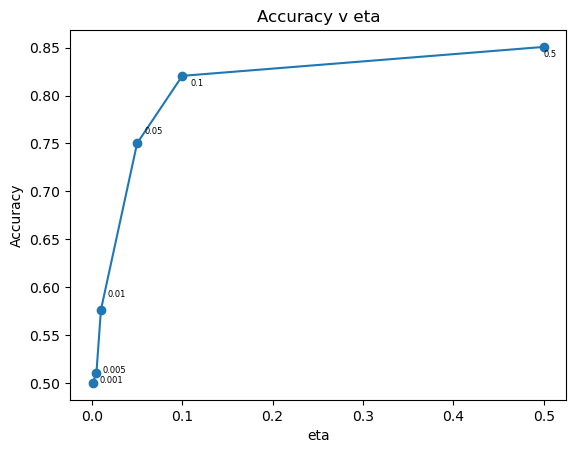

In [25]:
#plot the accuracy v eta
plt.plot(x, y,'-o')
plt.title('Accuracy v eta')
plt.xlabel('eta')
plt.ylabel('Accuracy')
plt.text(0.008, 0.50, '0.001', fontsize=6)
plt.text(0.012, 0.51, '0.005', fontsize=6)
plt.text(0.017, 0.59, '0.01', fontsize=6)
plt.text(0.058, 0.76, '0.05', fontsize=6)
plt.text(0.109, 0.81, '0.1', fontsize=6)
plt.text(0.5, 0.84, '0.5', fontsize=6)
#plt.text(0.9, 0.2, 'cos')
plt.show()